In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys

sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["axes.facecolor"] = [0.9, 0.9, 0.9]  # makes a grey background to the axis face
matplotlib.rcParams["axes.labelsize"] = 14  # font-size in pts
matplotlib.rcParams["axes.titlesize"] = 14
matplotlib.rcParams["xtick.labelsize"] = 12
matplotlib.rcParams["ytick.labelsize"] = 12
matplotlib.rcParams["legend.fontsize"] = 12
matplotlib.rcParams["legend.facecolor"] = "w"
matplotlib.rcParams["savefig.transparent"] = False

import sevirs
from sevirs.constants import VIL, VIS, IR_069, IR_107, LGHT

In [2]:
fg = sevirs.FeatureGenerator(
    "/mnt/data/sevir/",
    inputs=(sevirs.ImageType.VIS,),
    targets=(sevirs.ImageType.VIL,),
    patch_size="upscale",  # upscale the VIL image to the resolution of the VIS image
)


(x, y), df = fg.select("S858968", metadata=True)  # tuple[tuple[Tensor[C, X, Y, T], ...], pl.DataFrame]

vis, vil = x[0].numpy(), y[0].numpy()  # Tensor[C, X, Y, T] -> np.ndarray[X, Y, T]

df

INFO:root:Loading 81 files with 1 image types.
100%|██████████| 81/81 [00:02<00:00, 38.50it/s]
INFO:root:Loading 10 files with 1 image types.
100%|██████████| 10/10 [00:00<00:00, 33.81it/s]


id,img_type,file_name,file_index,time_utc,minute_offsets,episode_id,event_id,event_type,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon,proj,size_x,size_y,height_m,width_m,data_min,data_max,pct_missing,file_ref
str,str,str,i64,datetime[μs],str,f64,f64,str,f64,f64,f64,f64,str,i64,i64,f64,f64,f64,f64,f64,i32
"""S858968""","""vis""","""/mnt/data/sevi…",75,2019-09-17 19:54:00,"""-120:-115:-110…",142807.0,858968.0,"""Thunderstorm W…",46.167805,-94.760806,49.388668,-89.263121,"""+proj=laea +la…",768,768,384000.0,384000.0,0.033034,1.115368,0.0,71
"""S858968""","""vil""","""/mnt/data/sevi…",421,2019-09-17 19:54:00,"""-119:-114:-109…",142807.0,858968.0,"""Thunderstorm W…",46.167805,-94.760806,49.388668,-89.263121,"""+proj=laea +la…",384,384,384000.0,384000.0,0.0,254.0,0.0,3


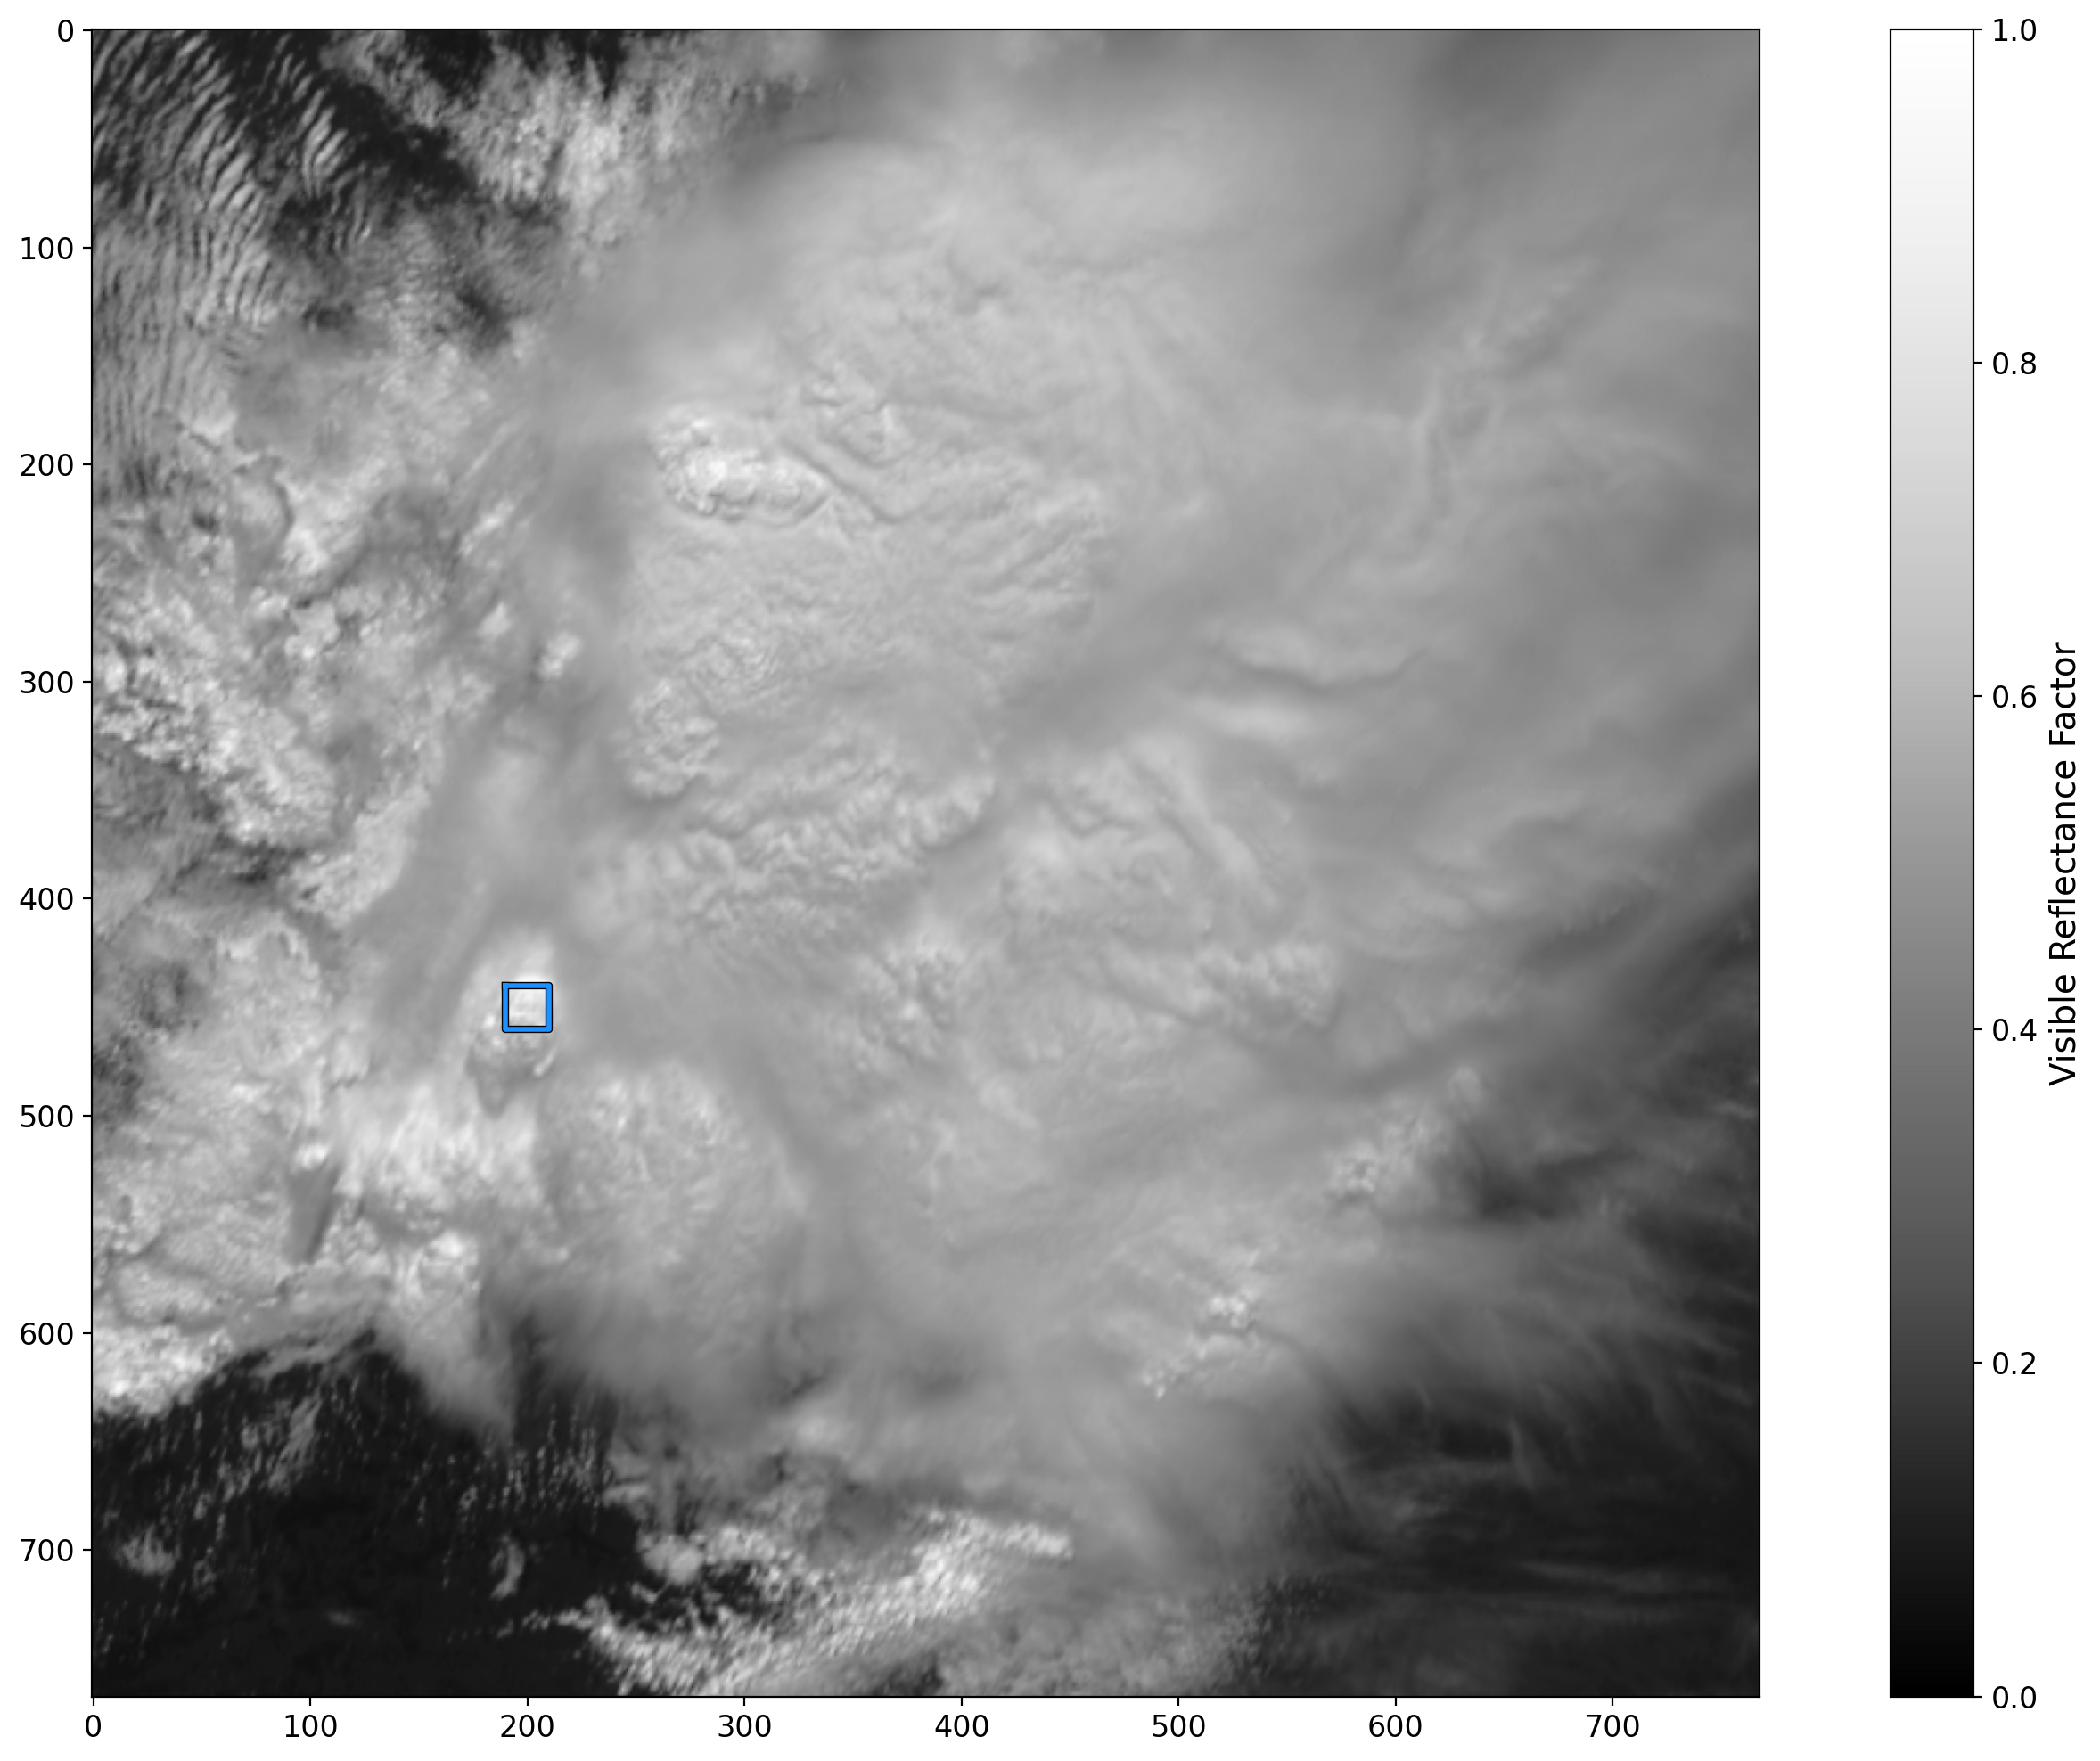

In [3]:
size = 10

plt.figure(figsize=(15, 10))
plt.imshow(vis[:, :, 0] * 1e-4, cmap="Greys_r", vmin=0, vmax=1)
xz, yz = sevirs.plot.zoombox(x=200, y=450, size=size)
plt.colorbar(label="Visible Reflectance Factor")
# a function that cleans some of the figure up.
plt.tight_layout()

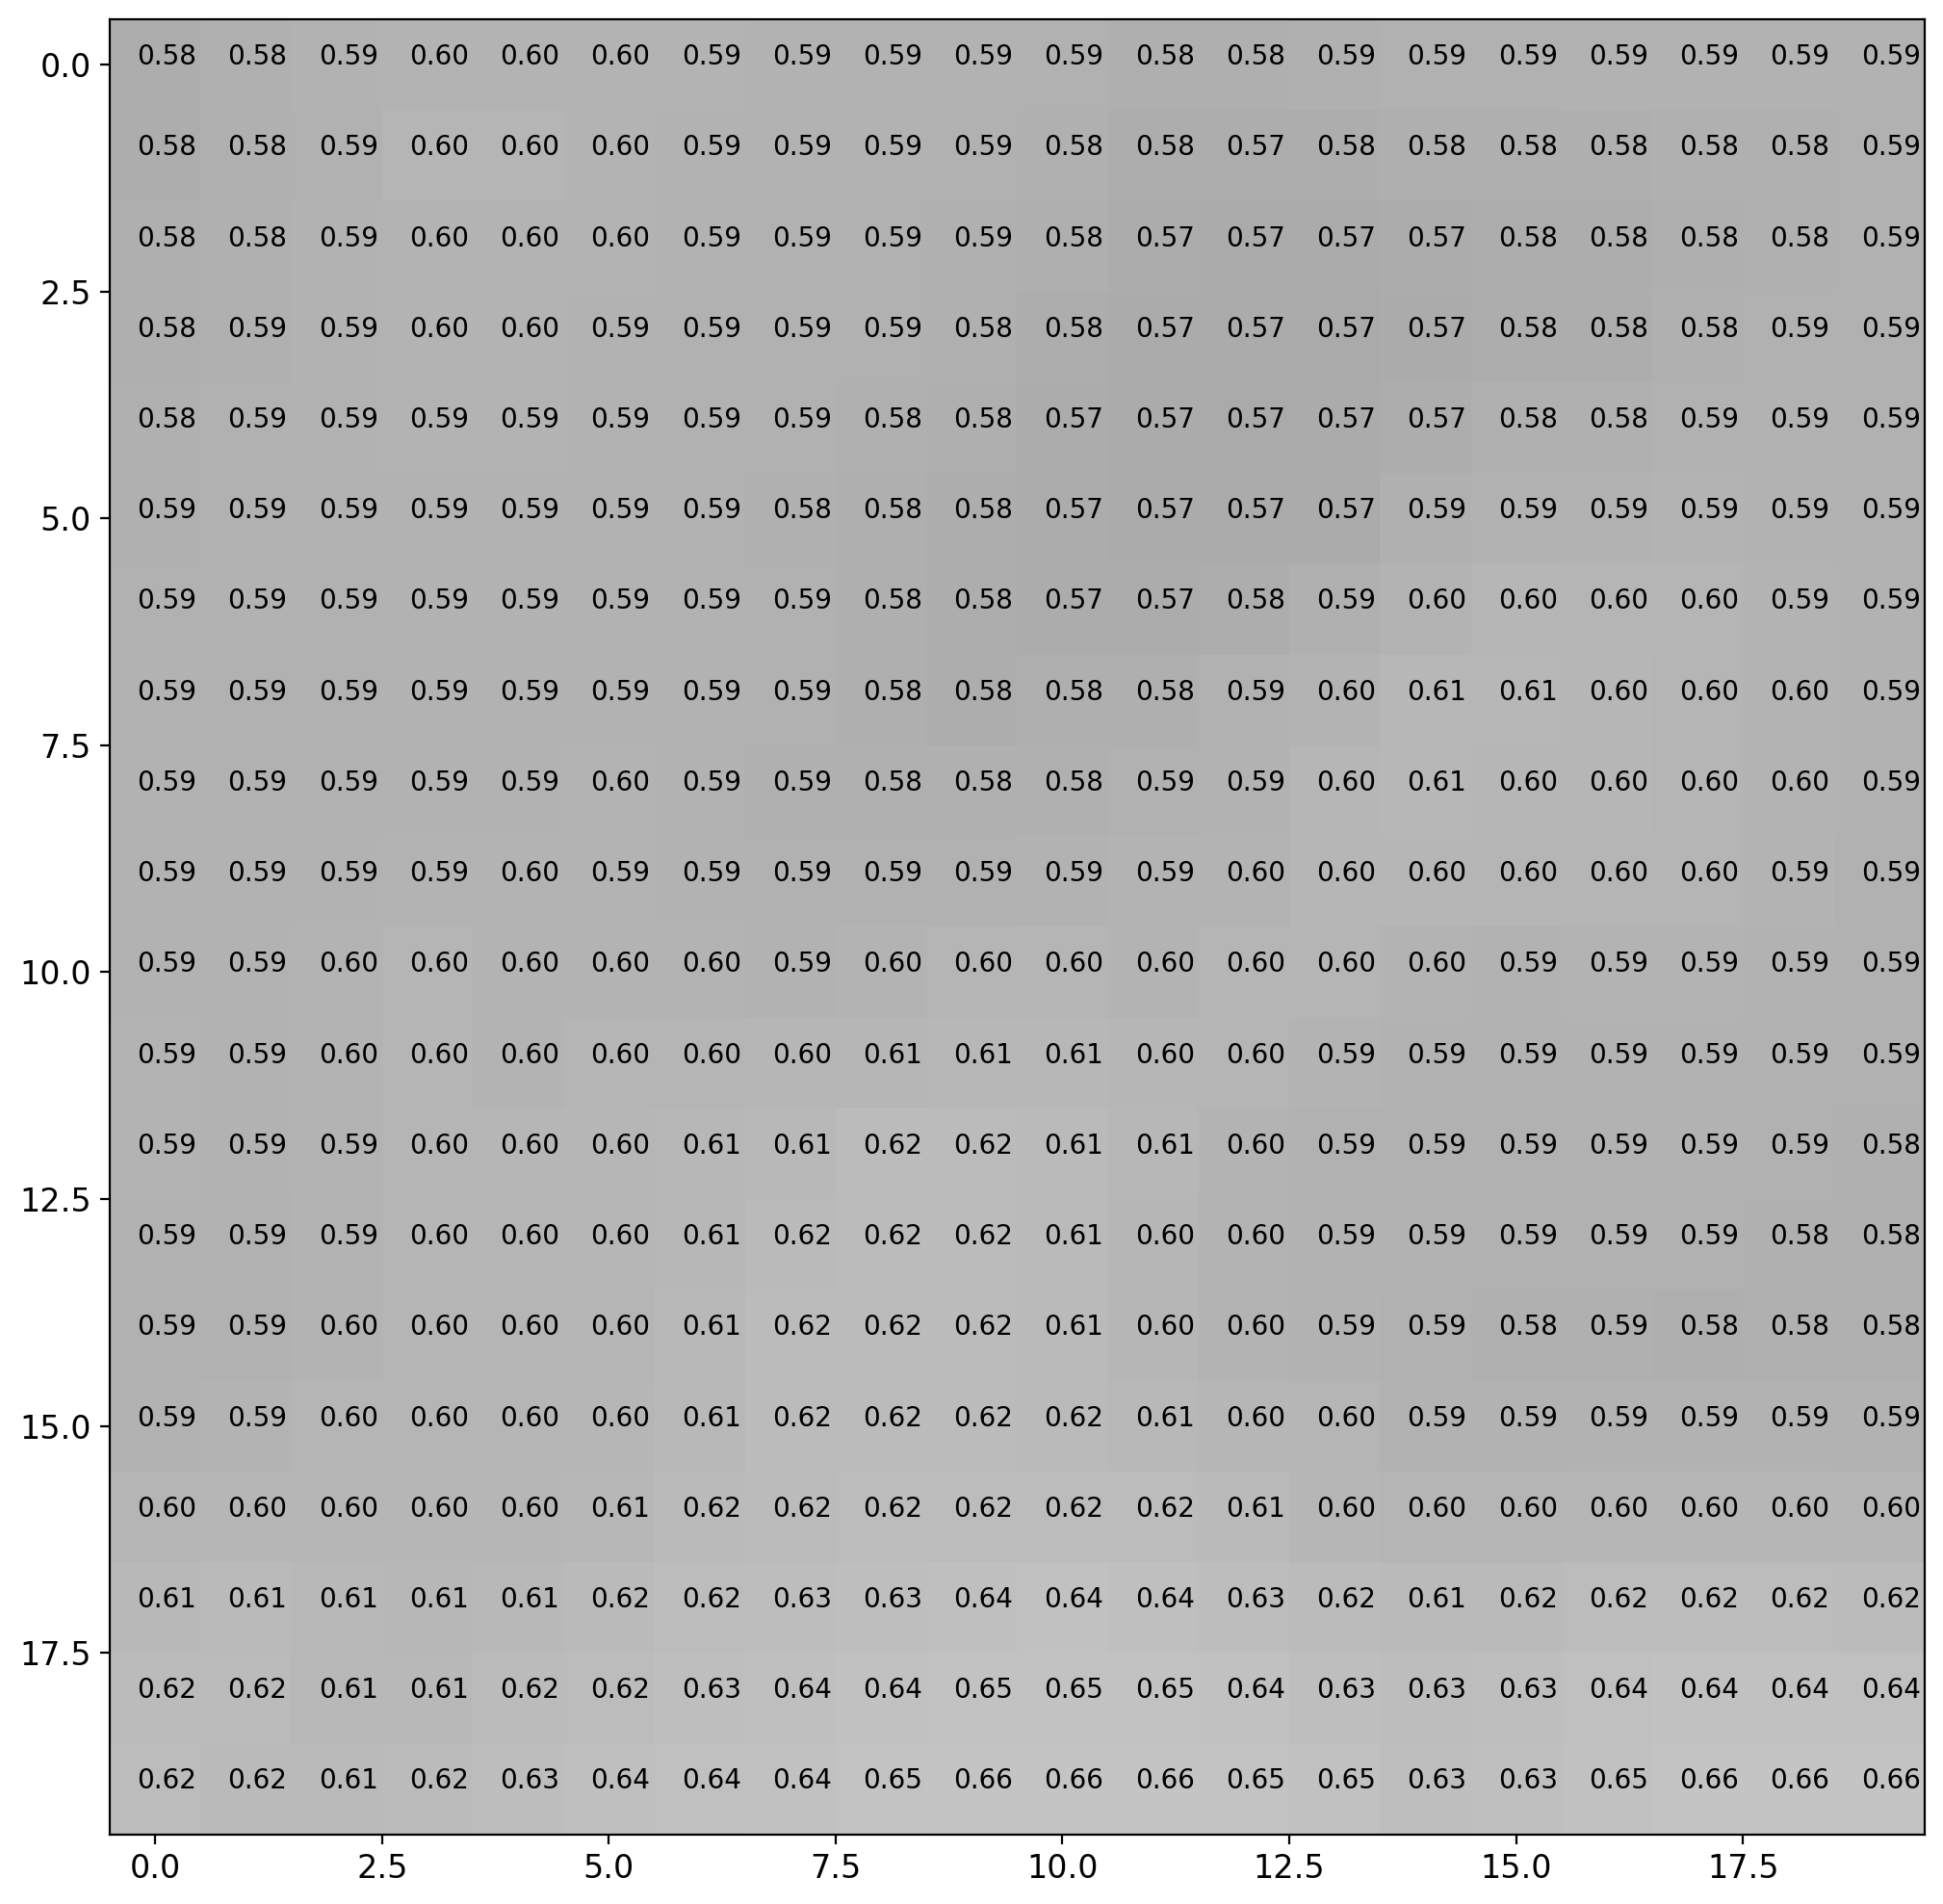

In [4]:
# make a figure with size 15 inches in the x, and 10 inches in the y
x0, y0, x1, y1 = xz - size, yz - size, xz + size, yz + size
arr = vis[x0:x1, y0:y1, 0] * 1e-4
plt.figure(figsize=(15, 10))
# show all x pixels (:) and all y pixels (:) and the first time step, with a Grey colorscale, and the color min 0 and color max 1.
plt.imshow(arr, cmap="Greys_r", vmin=0, vmax=1)
sevirs.plot.values(arr)

plt.tight_layout()

In [5]:
fg.close()

INFO:root:🏪 Closing Store 🏪


In [6]:
PATCH_SIZE = 256
INPUTS = (sevirs.ImageType.IR_107, sevirs.ImageType.IR_069, sevirs.ImageType.VIS)
TARGETS = (sevirs.ImageType.VIL,)

with sevirs.FeatureGenerator("/mnt/data/sevir", inputs=INPUTS, targets=TARGETS, patch_size=PATCH_SIZE) as gen:
    x, y = next(iter(gen))


x.shape, y.shape

INFO:root:Loading 101 files with 3 image types.
100%|██████████| 101/101 [00:01<00:00, 75.20it/s]
INFO:root:Loading 10 files with 1 image types.
100%|██████████| 10/10 [00:00<00:00, 70.06it/s]
INFO:root:🏃 Iterating over Dataset 🏃
  0%|          | 0/12741 [00:02<?, ?it/s]
INFO:root:🏪 Closing Store 🏪


(torch.Size([3, 256, 256, 49]), torch.Size([1, 256, 256, 49]))

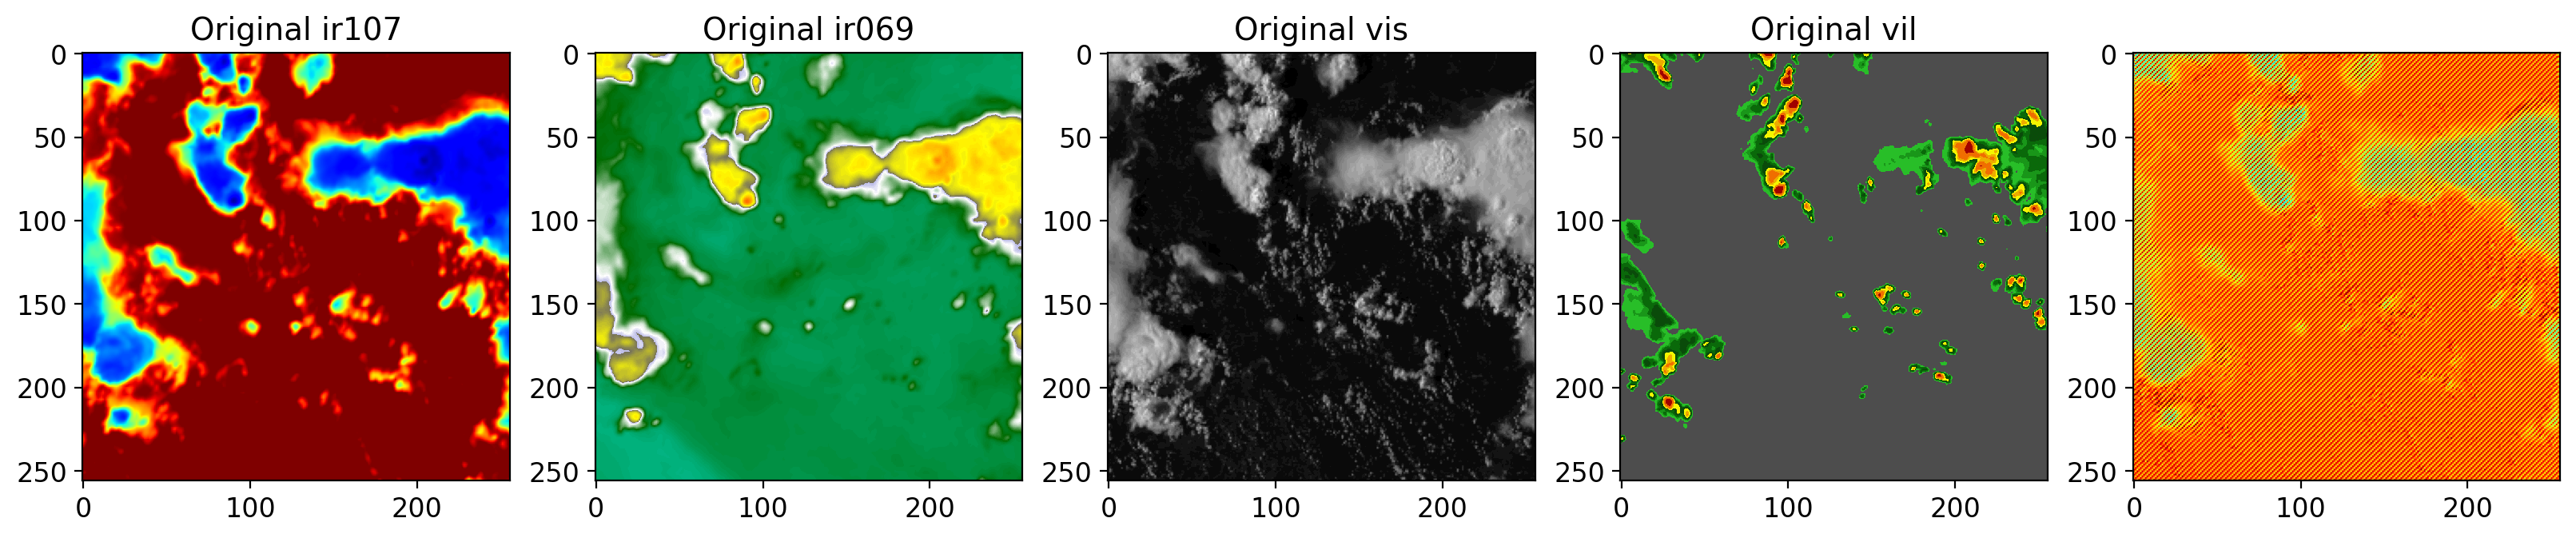

In [7]:
import numpy as np
import scipy.linalg
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt


x0 = x[:, :, :, 0]  # [C, X, Y]
a = np.array(x0)  # [C, X, Y]
a = a.reshape(-1, a.shape[0])  # [X * Y, C]
n_samples, n_features = a.shape  # [X * Y, C]
n_components = min(a.shape)


pca = PCA(
    n_components,
    # svd_solver="full",
    # # whiten=True,
    # random_state=21,
    # iterated_power=10,
    tol=1e-3,
    # whiten_solver="eigh",
)
pca_result = pca.fit_transform(a)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
IR_107.imshow(ax1, x[0, :, :, 0], title=f"Original {IR_107}", encoded=True)
IR_069.imshow(ax2, x[1, :, :, 0], title=f"Original {IR_069}", encoded=True)
VIS.imshow(ax3, x[2, :, :, 0], title=f"Original {VIS}", encoded=True)
VIL.imshow(ax4, y[0, :, :, 0], title=f"Original {VIL}", encoded=True)
IR_107.imshow(
    ax5,
    np.mean(pca_result.reshape(x0.shape), axis=0),
)
# ax5.set_title("PCA Reconstruction")